In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),   # Resize images to a fixed size
        transforms.ToTensor(),           # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.75,
                                 scale=(0.01, 0.3),
                                 ratio=(1.0, 1.0),
                                 value=0,
                                 inplace =True)        
    ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder('data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('data/validation', transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model

In [3]:
from torchsummary import summary

# Load the pretrained VGG16 model
vgg16 = models.vgg16()
f_extractor = vgg16.features

model = nn.Sequential(f_extractor, 
                      nn.Flatten(), 
                      nn.Dropout(0.3), 
                      nn.Linear(512*7*7, 512),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(512, 2))
                      


model.to(device)
summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

# Train

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)  

In [5]:
# Function to compute loss and accuracy for test set
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(test_loader)
    return test_loss, accuracy

In [6]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 10

In [7]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/10], Loss: 0.6957, Accuracy: 48.05%, Test Loss: 0.6891, Test Accuracy: 58.10%
Epoch [2/10], Loss: 0.6905, Accuracy: 54.25%, Test Loss: 0.6931, Test Accuracy: 50.60%
Epoch [3/10], Loss: 0.6887, Accuracy: 55.60%, Test Loss: 0.6879, Test Accuracy: 54.60%
Epoch [4/10], Loss: 0.6831, Accuracy: 54.55%, Test Loss: 0.6751, Test Accuracy: 56.60%
Epoch [5/10], Loss: 0.6644, Accuracy: 58.40%, Test Loss: 0.6638, Test Accuracy: 58.90%
Epoch [6/10], Loss: 0.6432, Accuracy: 59.65%, Test Loss: 0.6900, Test Accuracy: 60.00%
Epoch [7/10], Loss: 0.6551, Accuracy: 58.85%, Test Loss: 0.6693, Test Accuracy: 59.40%
Epoch [8/10], Loss: 0.6379, Accuracy: 61.00%, Test Loss: 0.6625, Test Accuracy: 63.60%
Epoch [9/10], Loss: 0.6112, Accuracy: 65.15%, Test Loss: 0.6170, Test Accuracy: 66.40%
Epoch [10/10], Loss: 0.6063, Accuracy: 65.00%, Test Loss: 0.7366, Test Accuracy: 64.20%


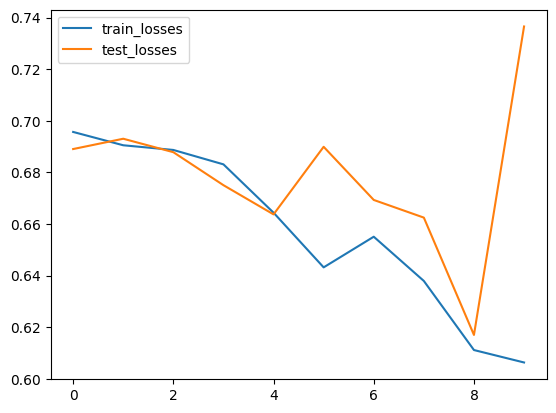

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

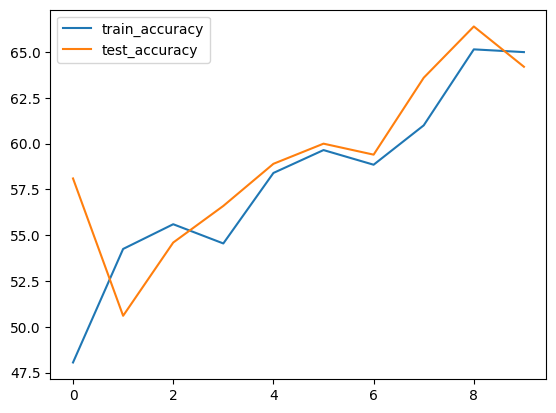

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [10]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [11]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()